# 第15章 画像の分類 ―ディープ畳み込みニューラルネットワーク―

## 15.1 畳み込みニューラルネットワークの構成要素

### 15.1.1 畳み込みニューラルネットワークと特徴量階層

最初にある方の層は生データから**低レベルの特徴量**を抽出する。

その後の層は連続値の目的変数やクラスレベルを予測する。

CNNは入力画像から**特徴量マップ**を計算する

### 15.1.2 離散畳み込みを実行する

### 15.1.3 サブサンプリング層

## 15.2 畳み込みニューラルネットワークを実装する

### 15.2.1 複数の入力チャネルを操作する

### 15.2.2 ドロップアウトによるニューラルネットワークの正則化

畳み込みまたは全結合のネットワークでL2正則化を使う方法

In [2]:
from tensorflow import keras
conv_layer = keras.layers.Conv2D(
    filters=16,
    kernel_size=(3, 3),
    kernel_regularizer=keras.regularizers.l2(0.001)
)
fc_layer = keras.layers.Dense(
    units=16,
    kernel_regularizer=keras.regularizers.l2(0.001)
)

**ドロップアウト**と呼ばれる正則化手法が登場している。

### 15.2.3 分類の損失関数

- 二値分類 用途：二値分類
- 正解ラベルがone-hotエンコーディング形式の多クラス分類 用途：多クラス分類
- 正解ラベル整数（疎クラス）の多クラス分類 用途：多クラス分類

数値的安定性を理由に、交差エントロピー損失関数の計算にはクラス所属確率ではなくロジットをていきょうすることが推奨される。

In [1]:
import tensorflow as tf

2025-01-01 07:32:47.982938: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
##### BinaryCrossentropy
bce_probas = tf.keras.losses.BinaryCrossentropy(from_logits=False)
bce_logits = tf.keras.losses.BinaryCrossentropy(from_logits=True)
logits = tf.constant([0.8])
probas = tf.keras.activations.sigmoid(logits)
tf.print("BCE (w  Probas): {:.4f}".format(bce_probas(y_true=tf.constant([1.0]), y_pred=probas)),
        "(w Logits): {:.4f}".format(bce_logits(y_true=tf.constant([1.0]), y_pred=logits)))

BCE (w  Probas): 0.3711 (w Logits): 0.3711


In [2]:
##### CategoricalCrossentropy
cce_probas = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
cce_logits = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
logits = tf.constant([1.5, 0.8, 2.1])
probas = tf.keras.activations.sigmoid(logits)
tf.print("CCE (w  Probas): {:.4f}".format(cce_probas(y_true=tf.constant([0, 0, 1]), y_pred=probas)),
        "(w Logits): {:.4f}".format(cce_logits(y_true=tf.constant([0, 0, 1]), y_pred=logits)))

CCE (w  Probas): 0.5996 (w Logits): 0.5996


In [3]:
##### SparseCategoricalCrossentropy
sp_cce_probas = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
sp_cce_logits = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
tf.print("Sparse CCE (w  Probas): {:.4f}".format(sp_cce_probas(y_true=tf.constant([2]), y_pred=probas)),
        "(w Logits): {:.4f}".format(sp_cce_logits(y_true=tf.constant([2]), y_pred=logits)))

Sparse CCE (w  Probas): 0.5996 (w Logits): 0.5996


## 15.3 TensorFlowを使ってディープ畳み込みニューラルネットワークを実装する

### 15.3.1 多層CNNアーキテクチャ

入力は28×28のグレースケール画像である。入力テンソルの次元が「バッチサイズ×28×28×1」である。

各層のテンソルの次元は次のようになる。

- **入力層** バッチサイズ×28×28×1
- **畳み込み層1** バッチサイズ×28×28×32
- **プーリング層1** バッチサイズ×14×14×32
- **畳み込み層2** バッチサイズ×28×28×64
- **プーリング層2** バッチサイズ×7×7×64
- **全結合層1** バッチサイズ×1024
- **全結合層2とソフトマックス層** バッチサイズ×10

### 15.3.2 データの読み込みと前処理

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

2025-01-01 08:53:19.218628: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import sagemaker


bucket = sagemaker.Session().default_bucket()
prefix = "mnist"

# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [3]:
import struct
import numpy as np
import boto3
import io
import gzip
import pickle
from pathlib import Path

In [4]:
def load_mnist(source_bucket_name, path, kind="train"):
    """MNISTデータをpathからロード"""
    s3 = boto3.resource("s3")
    bucket_minst = s3.Bucket(source_bucket_name)
    # 引数に指定したパスを結合
    labels_path = Path(path) / f"{kind}-labels-idx1-ubyte.gz"
    images_path = Path(path) / f"{kind}-images-idx3-ubyte.gz"
    # ファイルを読み込む：引数にファイル、モードを指定（rbは読み込みのバイナリモード）
    with io.BytesIO() as f:
        bucket_minst.download_fileobj(str(labels_path), f)
        f.seek(0)
        with gzip.open(f, mode='rb') as lbpath:
            # バイナリを文字列に変換：unpack関数の引数にフォーマット、8バイト分の
            # バイナリデータを指定してマジックナンバー、アイテムの個数を読み込む
            magic, n = struct.unpack(">II", lbpath.read(8))
            # ファイルからラベルを読み込み配列を構築：fromfile関数の引数に
            # ファイル、配列のデータ形式を指定
            labels = np.frombuffer(lbpath.read(), dtype=np.uint8)
    with io.BytesIO() as f:
        bucket_minst.download_fileobj(str(images_path), f)
        f.seek(0)
        with gzip.open(f, mode='rb') as imgpath:
            magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
            # 画像ピクセル情報の配列のサイズを変更（行数：ラベルのサイズ、列数：特徴量の個数）
            images = np.frombuffer(imgpath.read(), dtype=np.uint8).reshape(len(labels), 28, 28)
            images = ((images / 255.) - 0.5) * 2

    return images, labels

In [5]:
x_train_orig, y_train_orig = load_mnist(bucket, prefix, kind="train")

x_test_orig, y_test_orig = load_mnist(bucket, prefix, kind="t10k")

In [6]:
y_train_orig.shape

(60000,)

In [7]:
x_train_orig.shape

(60000, 28, 28)

In [8]:
y_test_orig.shape

(10000,)

In [9]:
x_test_orig.shape

(10000, 28, 28)

In [10]:
mnist_train = tf.data.Dataset.from_tensor_slices((x_train_orig, y_train_orig))

2025-01-01 08:53:32.228909: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 376320000 exceeds 10% of free system memory.


In [11]:
mnist_test = tf.data.Dataset.from_tensor_slices((x_test_orig, y_test_orig))

2025-01-01 08:53:32.890154: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 62720000 exceeds 10% of free system memory.


In [12]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
NUM_EPOCHS = 20

In [13]:
mnist_train = mnist_train.shuffle(buffer_size=BUFFER_SIZE,
                                 reshuffle_each_iteration=False)
mnist_valid = mnist_train.take(10000).batch(BATCH_SIZE)
mnist_train = mnist_train.skip(10000).batch(BATCH_SIZE)

In [14]:
mnist_train

<_BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>

In [15]:
mnist_valid

<_BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>

### 15.3.3 TensorFlow Keras APIを使ってCNNを実装する

In [16]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5), strides=(1, 1),
                                padding="same", data_format="channels_last",
                                name="conv_1", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name="pool_1"))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), strides=(1, 1),
                                 padding="same", name="conv_2", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name="pool_2"))

In [17]:
model.compute_output_shape(input_shape=(16, 28, 28, 1))

(16, 7, 7, 64)

In [18]:
model.add(tf.keras.layers.Flatten())
model.compute_output_shape(input_shape=(16, 28, 28, 1))

(16, 3136)

In [19]:
model.add(tf.keras.layers.Dense(units=1024, name="fc_1", activation="relu"))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(units=10, name="fc_2", activation="softmax"))

In [20]:
tf.random.set_seed(1)
model.build(input_shape=(None, 28, 28, 1))
model.compile(optimizer=tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             metrics=["accuracy"])

2025-01-01 08:53:48.142323: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 12845056 exceeds 10% of free system memory.
2025-01-01 08:53:48.161619: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 12845056 exceeds 10% of free system memory.
2025-01-01 08:53:48.169981: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 12845056 exceeds 10% of free system memory.


In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 28, 28, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 14, 14, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_1 (Dense)                    │ (None, 1024)           │     3,212,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_2 (Dense)                    │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,274,634 (12.49 MB)

 Trainable params: 3,274,634 (12.49 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
history = model.fit(mnist_train,
                   epochs=NUM_EPOCHS,
                   validation_data=mnist_valid,
                   shuffle=True)

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 174s 220ms/step - accuracy: 0.8979 - loss: 0.3232 - val_accuracy: 0.9828 - val_loss: 0.0541
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 192s 246ms/step - accuracy: 0.9840 - loss: 0.0515 - val_accuracy: 0.9815 - val_loss: 0.0632
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 163s 196ms/step - accuracy: 0.9885 - loss: 0.0369 - val_accuracy: 0.9814 - val_loss: 0.0631
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 133s 169ms/step - accuracy: 0.9923 - loss: 0.0240 - val_accuracy: 0.9808 - val_loss: 0.0646
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 131s 168ms/step - accuracy: 0.9944 - loss: 0.0182 - val_accuracy: 0.9799 - val_loss: 0.0785
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 132s 169ms/step - accuracy: 0.9932 - loss: 0.0186 - val_accuracy: 0.9875 - val_loss: 0.0523
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 140s 179ms/step - accuracy: 0.9948 - loss: 0.0145 - val_accuracy: 0.9842 - val_loss: 0.0763
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 168s 215ms/step - accuracy: 0.9956 -

In [26]:
model.save("./models/my_mnist_model.keras")

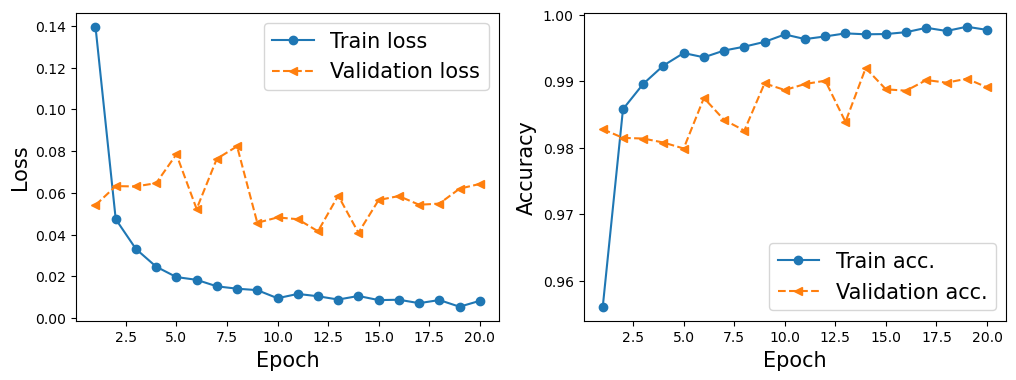

In [27]:
import matplotlib.pyplot as plt
hist = history.history
x_arr = np.arange(len(hist["loss"])) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist["loss"], "-o", label="Train loss")
ax.plot(x_arr, hist["val_loss"], "--<", label="Validation loss")
ax.set_xlabel("Epoch", size=15)
ax.set_ylabel("Loss", size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist["accuracy"], "-o", label="Train acc.")
ax.plot(x_arr, hist["val_accuracy"], "--<", label="Validation acc.")
ax.set_xlabel("Epoch", size=15)
ax.set_ylabel("Accuracy", size=15)
ax.legend(fontsize=15)
plt.show()

訓練したモデルをテストデータセットで評価するには`evaluate`メゾットを呼び出す。

In [28]:
test_results = model.evaluate(mnist_test.batch(20))
print("Test Acc.: {:.2f}%".format(test_results[1] * 100))

500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.9861 - loss: 0.0846
Test Acc.: 98.92%


In [29]:
batch_test = next(iter(mnist_test.batch(12)))
preds = model(batch_test[0])
tf.print(preds.shape)

TensorShape([12, 10])


In [30]:
preds = tf.argmax(preds, axis=1)
print(preds)

tf.Tensor([7 2 1 0 4 1 4 9 5 9 0 6], shape=(12,), dtype=int64)


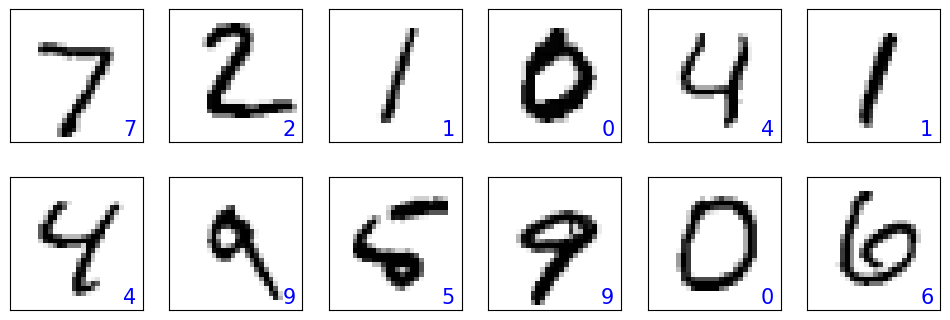

In [37]:
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    img = batch_test[0][i, :, :]
    ax.imshow(img, cmap="gray_r")
    ax.text(0.9, 0.1, "{}".format(preds[i]), size=15, color="blue",
           horizontalalignment="center", verticalalignment="center",
           transform=ax.transAxes)

plt.show()

## 15.4 CNNを使って顔画像から性別を予測する

### 15.4.1 CelebA データセットを読み込む

In [1]:
import tensorflow as tf

2025-01-02 10:37:59.276134: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


CelebAデータセットは、訓練データセット、検証データセット、テストデータセットに分かれている。

In [14]:
import sagemaker


bucket = sagemaker.Session().default_bucket()
prefix = "Celeb_A"

# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

In [21]:
from pathlib import Path

In [13]:
print(bucket)

sagemaker-ap-northeast-1-202533513976


S3からデータセットをダウンロードする。

In [3]:
s3 = boto3.resource("s3")
bucket_minst = s3.Bucket(bucket)

In [18]:
prefix_path = "Celeb_A/"

In [39]:
download_path = Path("/home/sagemaker-user/tensorflow_datasets/celeb_a/2.0.1/").resolve()

In [47]:
for obj in bucket_minst.objects.filter(Prefix=prefix_path):
    # print((download_path / Path(obj.key).relative_to(prefix_path)))
    main_path = download_path / Path(obj.key).relative_to(prefix_path)
    main_path.parent.mkdir(parents=True, exist_ok=True)
    with open(main_path, mode="wb") as local_f:
        bucket_minst.download_fileobj(obj.key, local_f)

In [49]:
%pip install tensorflow-datasets

  Using cached tensorflow_datasets-4.9.7-py3-none-any.whl.metadata (9.6 kB)
  Using cached dm_tree-0.1.8-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.9 kB)
  Using cached immutabledict-4.2.1-py3-none-any.whl.metadata (3.5 kB)
  Using cached promise-2.3-py3-none-any.whl
  Using cached simple_parsing-0.1.6-py3-none-any.whl.metadata (7.3 kB)
  Using cached tensorflow_metadata-1.16.1-py3-none-any.whl.metadata (2.4 kB)
  Using cached toml-0.10.2-py2.py3-none-any.whl.metadata (7.1 kB)
  Using cached array_record-0.6.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (692 bytes)
  Using cached etils-1.11.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached docstring_parser-0.16-py3-none-any.whl.metadata (3.0 kB)
Using cached tensorflow_datasets-4.9.7-py3-none-any.whl (5.3 MB)
Using cached array_record-0.6.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.3 MB)
Using cached etils-1.11.0-py3-none-any.whl (165 kB)
Using cached dm_tree-0.1

In [50]:
import tensorflow_datasets as tfds

In [68]:
celeba = tfds.load('celeb_a:2.0.1', download=False, shuffle_files=False)
celeba_train = celeba["train"]

AssertionError: Failed to construct dataset "celeb_a", builder_kwargs "{'version': '2.0.1', 'data_dir': None}": Dataset celeb_a cannot be loaded at version 2.0.1, only: 2.1.0.

上手くいかないので実行しないで進める

### 15.4.2 画像変換とデータ拡張

**データ拡張**または**データの水増し**は、訓練データが限られている状況に対処する様々な手法の総称である。

1. 画像を矩形に切り抜く。
2. 水平方向に反転させる。
3. コントラストを調整する。
4. 明度を調整する。
5. 画像を中心でくり抜き、元のサイズ (218 × 178)に戻す。

In [ ]:
import matplotlib.pyplot as plt
# 5つの訓練データを取得
examples = []
for example in celeba_train.take(5):
    examples.append(example["image"])

In [ ]:
fig = plt.figure(figsize=(16, 8.5))
## 列1：画像を矩形に切り抜く
ax = fig.add_subplot(2, 5, 1)
ax.set_title("Crop to a \nbounding-box", size=15)
ax.imshow(examples[0])
ax = fig.add_subplot(2, 5, 6)
img_cropped = tf.image.crop_to_bounding_box(examples[0], 50, 20, 128, 128)
ax.imshow(img_cropped)
## 列2：水平方向に反転させる
ax = fig.add_subplot(2, 5, 2)
ax.set_title("Flip (horizontal)", size=15)
ax.imshow(examples[1])
ax = fig.add_subplot(2, 5, 7)
img_flipped = tf.image.flip_left_right(examples[1])
ax.imshow(img_flipped)
## 列3：コントラストを調整する
ax = fig.add_subplot(2, 5, 3)
ax.set_title("Adjust contrast", size=15)
ax.imshow(examples[2])
ax = fig.add_subplot(2, 5, 8)
img_adj_contrast = tf.image.adjust_contrast(examples[2], contrast_factor=2)
ax.imshow(img_adj_contrast)
## 列4：明度を調整する
ax = fig.add_subplot(2, 5, 4)
ax.set_title("Adjust brightness", size=15)
ax.imshow(examples[3])
ax = fig.add_subplot(2, 5, 9)
img_adj_brightness = tf.image.adjust_brightness(examples[3], delta=0.3)
ax.imshow(img_adj_brightness)
## 列5：画像を中心でくり抜き、元のサイズ (218×178) に戻す
ax = fig.add_subplot(2, 5, 5)
ax.set_title("Central crop\nand resize", size=15)
ax.imshow(examples[4])
ax = fig.add_subplot(2, 5, 10)
img_center_crop = tf.image.resize(examples[4], delta=0.7)
img_resized = tf.image.resize(img_center_crop, size=(218, 178))
ax.imshow(img_resized.numpy().astype("uint8"))
plt.show()

コードで定義した変換は決定論的なものである。しかし、これらすべての返還をランダムに適用することもできる。<br>
モデルの訓練時のデータ拡張にはこの方法が推奨される。

- ランダムな矩形（左上の座標をランダムに選択する）を画像からくり抜く。
- 水平軸または垂直軸に沿って（0.5の確率で）画像をランダムに反転させる。
- 画像のコントラストをランダムに変化させる（`contrast_factor`をランダムに選択する）

In [ ]:
tf.random.set_seed(1)
fig = plt.figure(figsize=(14, 12))
for i, example in enumerate(celeba_train.take(3)):
    image = example["image"]
    ax = fig.add_subplot(3, 4, i*4+1)
    ax.imshow(image)
    if i == 0:
        ax.set_title("Orig", size=15)

    ax = fig.add_subplot(3, 4, i*4+2)
    img_crop = tf.image.random_crop(image, size=(178, 178, 3))
    ax.imshow(img_crop)
    if i == 0:
        ax.set_title("Step 1: Random crop", size=15)
    ax = fig.add_subplot(3, 4, i*4+3)
    img_flip = tf.image.random_flip_left_right(img_crop)
    ax.imshow(tf.cast(img_flip, tf.uint8))
    if i == 0:
        ax.set_title("Step 2: Random flip", size=15)
    ax = fig.add_subplot(3, 4, i*4+4)
    img_resize = tf.image.resize(img_flip, size=(128, 128))
    ax.imshow(tf.cast(img_resize, tf.uint8))
    if i == 0:
        ax.set_title("Step 3: Resize", size=15)

plt.show()

In [ ]:
def preprocess(example, size=(64, 64), mode="train"):
    image = example["image"]
    label = example["attributes"]["Male"]
    if mode == "train":
        image_cropped = tf.image.random_crop(image, size=(178, 178, 3))
        image_resized = tf.image.resize(image_cropped, size=size)
        image_flip = tf.image.random_flip_left_right(image_resized)
        return (image_flip/255.0, tf.cast(label, tf.int32))
    else: # 非訓練データでは、ランダムな切り抜きではなく中央での切り抜きを行う
        image_cropped = tf.image.crop_to_bounding_box(
            image, offset_height=20, offset_width=0,
            target_height=178, target_width=178)
        image_resized = tf.image.resize(image_cropped, size=size)
        return (image_resized/255.0, tf.cast(label, tf.int32))

In [ ]:
tf.random.set_seed(1)
ds = caleba_train.shuffle(1000, reshuffle_each_iteration=False)
ds = ds.take(2).repeat(5)
ds = ds.ds.map(lambda x:preprocess(x, size=(178, 178), mode="train"))
fig = plt.figure(figsize=(15, 6))
for j, example in enumerate(ds):
    ax = fig.add_subplot(2, 5, j//2+(j%2)*5+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(example[0])

plt.show()

次に、`preprocess`関数を訓練データセットと検証データセットに適用する。

In [ ]:
import numpy as np
BATCH_SIZE = 32
BUFFER_SIZE = 1000
IMAGE_SIZE = (64, 64)
steps_per_epoch = np.ceil(16000/BATCH_SIZE)
ds_train = celeba_train.map(lambda x: preprocess(x, size=IMAGE_SIZE, mode="train"))
ds_train = ds_train.shuffle(buffer_size=BUFFER_SIZE).repeat()
ds_train = ds_train.batch(BATCH_SIZE)
ds_valid = celeba_valid.map(lambda x: preprocess(x, size=IMAGE_SIZE, mode="eval"))
ds_valid = ds_valid.batch(BATCH_SIZE)

### 15.4.3 CNN性別分類器を訓練する

In [ ]:
model = tf.keras.Sequential([
    ## 1つ目の畳み込み層、最大値プーリング層、ドロップアウト層
    tf.keras.layers.Conv2D(32, (3, 3), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(rate=0.5),
    ## 2つ目の畳み込み層、最大値プーリング層、ドロップアウト層
    tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(rate=0.5),
    ## 3つ目の畳み込み層、最大値プーリング層
    tf.keras.layers.Conv2D(１２８, (3, 3), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    ## 4つ目の畳み込み層
    tf.keras.layers.Conv2D(256, (3, 3), padding="same", activation="relu")])

これらの層を適用した後の出力特徴量マップの形状を見てみよう。

In [ ]:
model.compute_output_shape(input_shape=(None, 64, 64, 3))
# TensorShape([None, 8, 8, 256])

In [ ]:
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.compute_output_shape(input_shape=(None, 64, 64, 3))
# TensorShape([None, 256])

In [ ]:
mode.add(tf.keras.layers.Dense(1, activation=None))
tf.random.set_seed(1)
model.build(input_shape=(None, 64, 64, 3))
model.summary()

モデル出力が1つだけの2値分類なので、`BinaryCrossentropy`を使うべき<br>
最後の層はシグモイド活性化関数を適用しないため(`activation=None`)、モデルの出力は確率ではなくロジットである。<br>
`BinaryCrossentropy`に`from_logits=True`を指定して、内部で損失関数にシグモイド関数を適用させる。

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             metrics=["accuracy"])
history = model.fit(ds_train, validation_date=ds_valid,
                   epochs=20, steps_per_epoch=steps_per_epoch)

学習曲線を可視化して、訓練時と検証時の損失率と正解率をエポックごとに比較しよう。

In [ ]:
hist = history.history
x_arr = np.arange(len(hist["loss"])) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist["loss"], "-o", label="Train loss")
ax.plot(x_arr, hist["val_loss"], "--<", label="Validation loss")
ax.legend(fontsize=15)
ax.set_xlabel("Epoch", size=15)
ax.set_ylabel("Loss", size=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist["accuracy"], "-o", label="Train acc.")
ax.plot(x_arr, hist["val_accuracy"], "--<", label="Validation acc.")
ax.legend(fontsize=15)
ax.set_xlabel("Epoch", size=15)
ax.set_ylabel("Accuracy", size=15)
plt.show()

In [ ]:
history = model.fit(ds_train, validation_data=ds_valid, epochs=30, initial_epoch=20, steps_per_epoch=steps_per_epoch)

In [ ]:
ds_test = celeba_test.map(
    lambda x:preprocess(x, size=IMAGE_SIZE, mode="eval")).batch(32)
test_results = model.evaluate(ds_test, verbose=0)
print("Test Acc: {:.2f}%".format(test_results[1]*100))

In [ ]:
ds = ds_test.unbatch().take(10)
pred_logits = model.predict(ds.batch(10))
probas = tf.sigmoid(pred_logits)
probas = probas.numpy().flatten()*100
fig = plt.figure(figsize=(15, 7))
for j, example in enumerate(ds):
    ax = fig.add_subplot(2, 5, j+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(example[0])
    if example[1].numpy() == 1:
        label="Male"
    else:
        label="Female"
    ax.test(0.5, -0.15, "GT: {:s}\nPr(Male)={:.0f}%".format(label, probas[j]),
            size=16,
            horizontalalignment="center",
            verticalalignment="center",
            transform=ax.transAxes)